# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

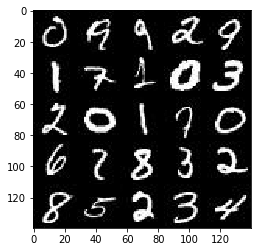

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

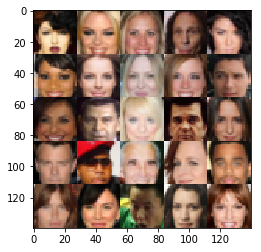

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_size = (image_width,image_height,image_channels)
    real_inputs = tf.placeholder(tf.float32, [None,*real_size],name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    lr = tf.placeholder(tf.float32,name='learning_rate')
    return real_inputs, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1,x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,trainable=True)
        x2 = tf.maximum(alpha*x2,x2)
        #print(x2.shape)
    
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,trainable=True)
        x3 = tf.maximum(alpha*x3,x3)
        #print(x3.shape)
        
        x4 = tf.reshape(x3,(-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [10]:
def generator(z, out_channel_dim,is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.conv2d_transpose(x1,512,5,strides=2,padding='valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2,64,4,strides=1,padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
    
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=4, strides=1, padding='same')
        out = tf.tanh(logits)
        
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smoothed = tf.ones_like(d_model_real) * 0.9
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(smoothed)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    
    num,weight,height,channels = data_shape
    real_in, z_in, lr = model_inputs(weight, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_in, z_in, channels)
    model_opt_instance = model_opt(d_loss,g_loss,lr,beta1)
    
    
    # init
    samples, losses = [], []
    steps = 0
    
    print_every = 10
    show_every = 100
    display_q = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(model_opt_instance, feed_dict={real_in: batch_images, z_in: batch_z,lr : learning_rate})
                _ = sess.run(model_opt_instance, feed_dict={z_in: batch_z, real_in: batch_images,lr : learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_in: batch_z, real_in: batch_images})
                    train_loss_g = g_loss.eval({z_in: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, display_q,  z_in, channels, data_image_mode)
                    
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.6198


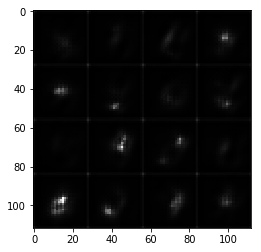

Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.5779... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.7653


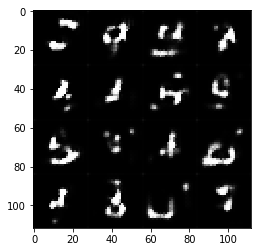

Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.8114


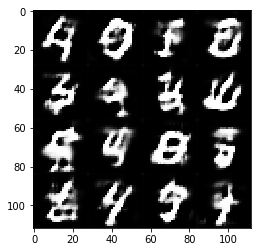

Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.7630


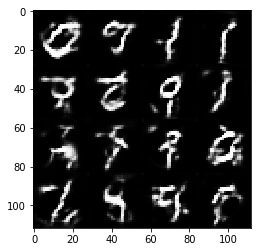

Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.6745


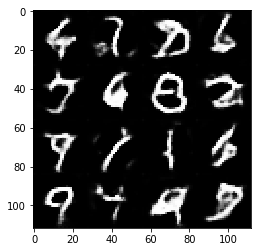

Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.7267
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.7390


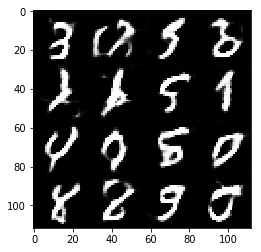

Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.8172


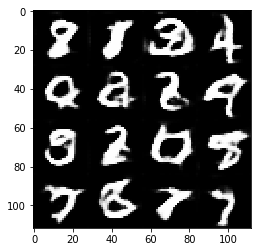

Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.6798
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.7616
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.7293


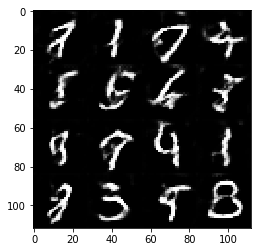

Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.7539


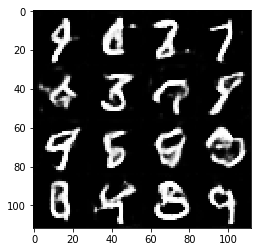

Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.7711


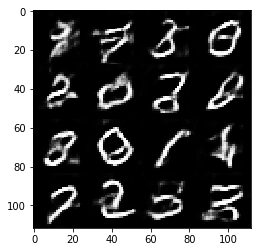

Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.7728
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.7838


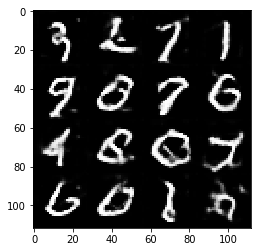

Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.8233


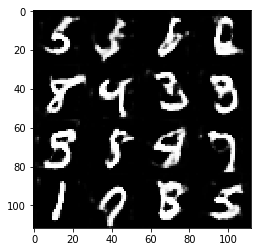

Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.1945... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.8306


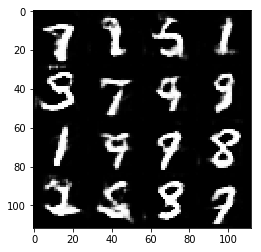

Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.7380


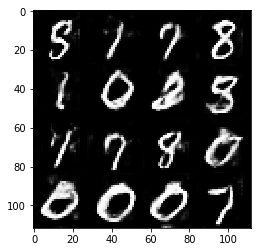

Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.7470


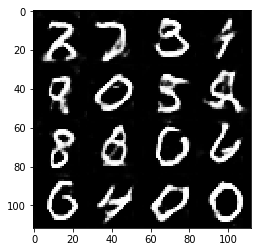

Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8573
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.9080


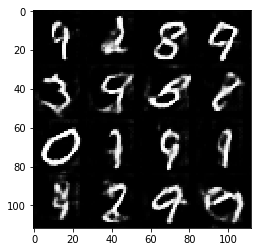

Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.8169
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.6914


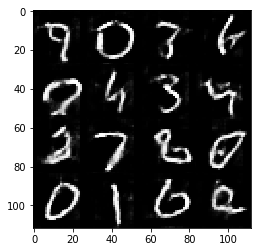

Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6126
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.8189


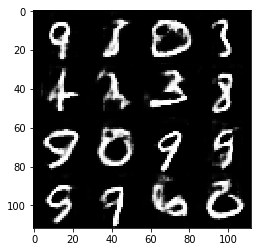

Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.8495


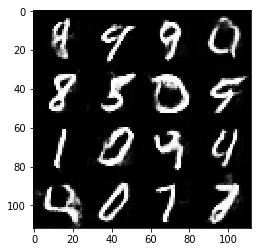

Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8022


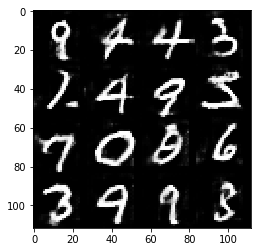

In [16]:
batch_size = 60
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

|*epoch*|*z_dim*|*batch_size*|*alpha*|*lr*|*beta1*|*g_loss*|*d_loss *|
- | :-: | -: 
| 3 | 100 |70 | 0.2 | 0.0002|0.5|1.3110| 0.7435|

Epoch 1/2... Discriminator Loss: 0.2503... Generator Loss: 3.0422
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 2.7554
Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 1.7764
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.5566
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.8036


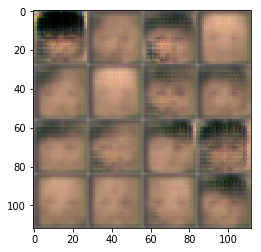

Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.7986


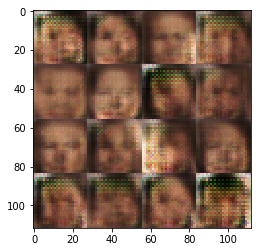

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.5496... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.6886


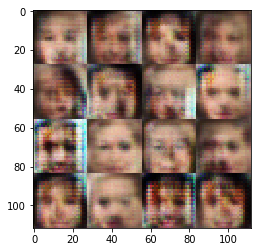

Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.6916


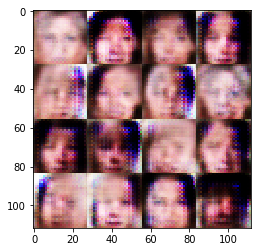

Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7538


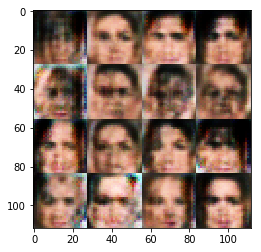

Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.2994... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.5604
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.6684


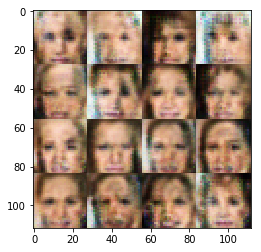

Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.6842


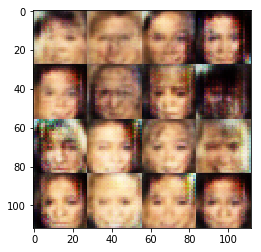

Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.7414


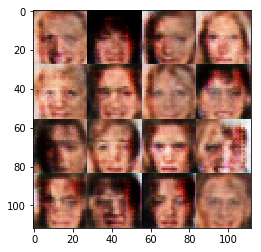

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7240


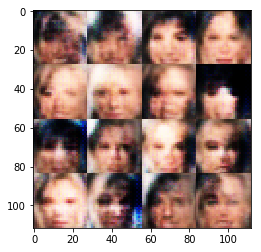

Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.7826


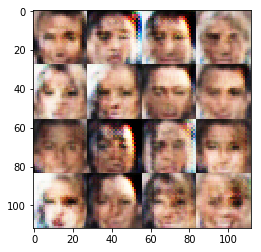

Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.5432


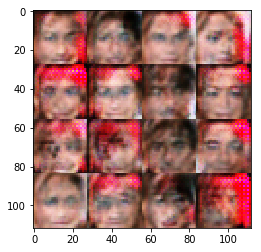

Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 1.1149
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.7643


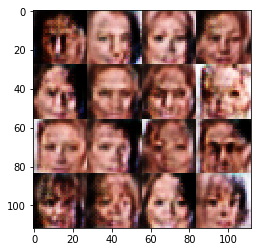

Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.7540


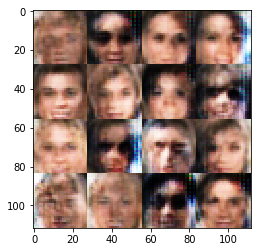

Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.4926
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.7631


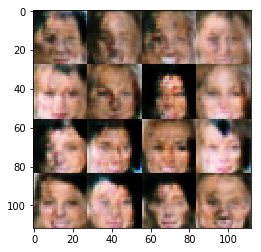

Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 1.4709
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.8149


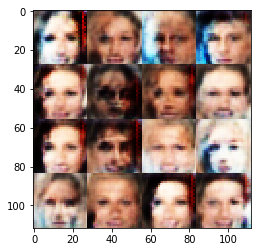

Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 1.2885
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.7480
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.7882


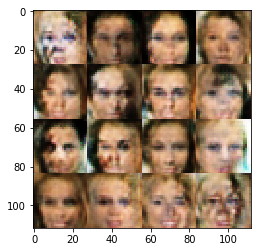

Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.4399... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.7074


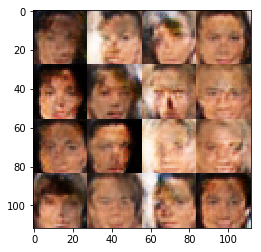

Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 1.0332
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.7538


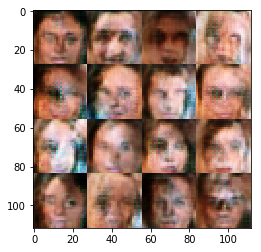

Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.8877


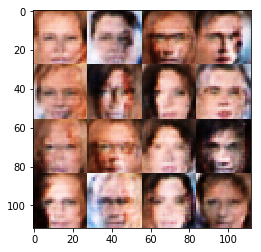

Epoch 2/2... Discriminator Loss: 1.2939... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.6539


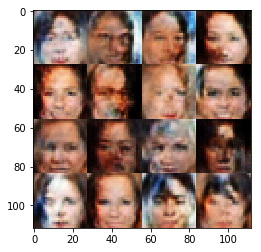

Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.7327


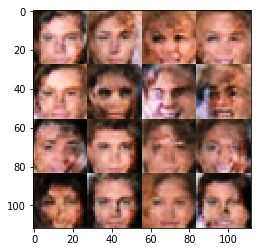

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.6103


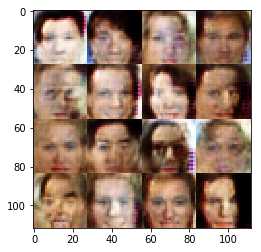

Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.7006


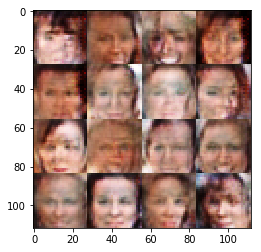

Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.8372


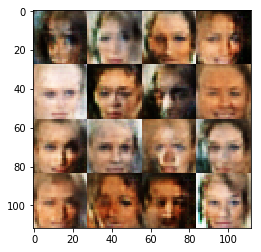

Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.2939... Generator Loss: 0.6590


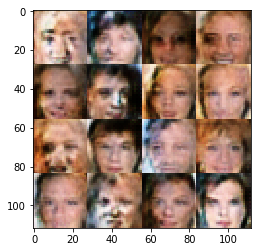

Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.7075


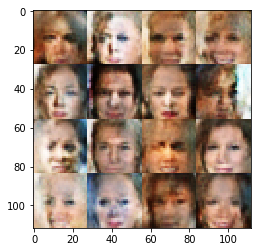

Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.9188
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.7329


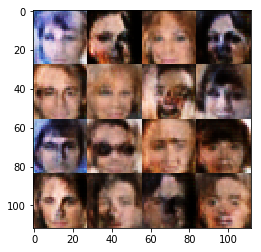

Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.2022... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.7766


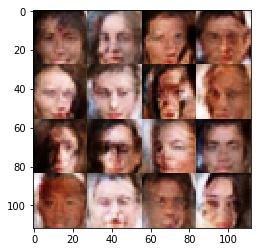

Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.8727


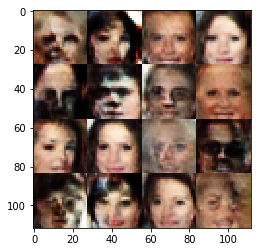

Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.7742
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.8108
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.7546


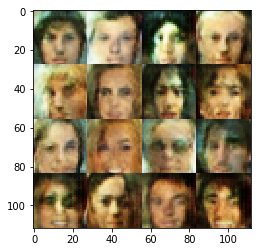

Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.8174
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.9378
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 1.1414
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.9312


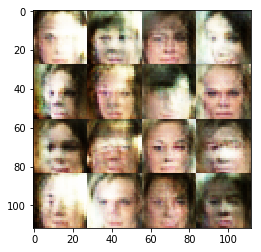

Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.8367


In [21]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。